In [35]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools
import pydot
from IPython.display import SVG
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'gfci', testId = 'sem-bic', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))

def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = df[key]
    return retval

def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    #x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        #x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True, penalty = 200
              )

    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)

num_models = 50  
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()

inputs = ["Temp", "Atemp", "Humidity", "Windspeed"]
target =  ["Count"]


categoricals = [] 




In [50]:
df = pd.read_csv('~/Desktop/Kaggle/Bike-Sharing-Dataset/hour.csv', names = ["Temp", "Atemp", "Humidity", "Windspeed", "Count"], usecols = [10, 11, 12, 13, 16])
df = df[1:]

In [51]:
len(df)

17379

[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256]] ['temp/bike0', 'temp/bike1', 'temp/bike2', 'temp/bike3', 'temp/bike4', 'temp/bike5', 'temp/bike6', 'temp/bike7', 'temp/bike8', 'temp/bike9', 'temp/bike10', 'temp/bike11', 'temp/bike12', 'temp/bike13', 'temp/bike14', 'temp/bike15', 'temp/bike16', 'temp/bike17', 'temp/bike18', 'temp/bike19', 'temp/bike20', 'temp/bike21', 'temp/bike22', 'temp/bike23', 'temp/bike24', 'temp/bike25', 'temp/bike26', 'te

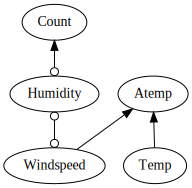

In [38]:
temporal = [['Temp', 'Atemp', 'Humidity', 'Windspeed'], ['Count']]
prior = p.knowledge(requiredirect= [('Temp', 'Atemp'),('Windspeed', 'Atemp')],
                   addtemporal = temporal
                   )
g = examine_graph_continuous(df, prior)
dot_str = pc.tetradGraphToDot(g)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

known_conx = set({})
for i in tetrad.getEdges():
    if ' --> ' in i:
        known_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))


prior = p.knowledge(requiredirect =  list(map(list, known_conx)),)

n_holdout = int(len(df) * 0.2)
df['Count'] = normalize(df['Count'].values.astype(int))
models = []
model_names = []

df['Temp'] = df['Temp'].values.astype(float)
df['Atemp'] = df['Atemp'].values.astype(float)
df['Windspeed'] = df['Windspeed'].values.astype(float)
df['Humidity'] = df['Humidity'].values.astype(float)
original_df = df.copy()
randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/random' + str(i))
    print(models, model_names)    
else:
    model_layers = [512,256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/bike' + str(i))

print(models, model_names)
SVG(svg_str)

In [39]:
prior = p.knowledge(requiredirect= [('Temp', 'Atemp'),('Windspeed', 'Atemp'),('Windspeed', 'Humidity'), ('Temp', 'Count'),('Humidity', 'Count')])
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal


forbiddirect

requiredirect
Windspeed Atemp
Temp Atemp
Humidity Count
Windspeed Humidity
Temp Count

In [40]:
num_models = 1

In [44]:
bestMSE = []
bestBIC = []
bestCOMBO = []
for t in range(10):
    # let's split our df into two by race.  Let's see what happens if we 
    df = original_df.copy()



    holdout = int(len(df) * 0.2)
        #df_test = df[df['charges'] > 0.54].copy()
    continuous = ["Count",  "Humidity", "Atemp", "Windspeed"]
    
    
    small = random.randint(0,1)
    cont = random.randint(0, len(continuous) - 1)
    if small == 0:
        df_test = df.nsmallest(holdout, continuous[cont])
    else:
        df_test = df.nlargest(holdout, continuous[cont])
    
    print(t, small, continuous[cont])

    '''
        end_idx = len(df) - holdout
    cont = random.randint(0, len(continuous) - 1)
    start_idx = random.randint(0, end_idx)
    print(t, "Doing range:",start_idx, start_idx + holdout, "and ", continuous[cont])
    df_test = df.nlargest(len(df) - start_idx, continuous[cont]).nsmallest(holdout, continuous[cont])
    '''


    
    df.drop(df_test.index, inplace = True)
    df_test.reset_index(inplace = True)
    df.sample(frac= 1).reset_index(inplace = True) # this will shuffle and reset index

    x_test = df_test[inputs]
    y_test = df_test[target]

    causal_split = 0.2
    val_split = 0.2
    train_split = 1 - (causal_split + val_split)

    x_causal = df[inputs][-int(causal_split * len(df)) :]
    y_causal = df[target][-int(causal_split * len(df)) :]

    x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
    y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]

    x_train = df[inputs][:int(train_split * len(df))]
    y_train = df[target][:int(train_split * len(df))]
    len(x_causal), len(y_causal), len(x_val), len(y_val), len(x_train), len(y_train)



    x_test_NN = x_test
    x_causal_NN = x_causal
    x_val_NN = x_val
    x_train_NN = x_train

    verbosity = 0


    for idx, model_name in enumerate(model_names):
        #print(model_name)

        if type(models[idx]) is list:
            #clear session
            keras.backend.clear_session() 
            #get model according to specification
            model = get_model(models[idx], [0.2] * len(models), np.shape(x_train_NN)[1])
            callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                         EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
            model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
            #print(len(X), len(y))
            model.fit(x_train_NN, y_train, epochs = 20, validation_data = (x_val_NN, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
        else:
            models[idx].fit(X,y)




    generalization = []
    metrics = []
    proposed = []
    x_causal.reset_index(drop = True, inplace = True)

    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(x_test_NN)
        generalization.append(mean_squared_error(y_pred, y_test))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal_NN)
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)



        metrics.append(mean_squared_error(y_causal_pred, y_causal))
        #print(x_causal.head)
        bic_pred = get_bic(causal_df, prior)
        #print(bic_pred, tetrad.getEdges())


        proposed.append(bic_pred)

    total = normalize(metrics) + normalize(proposed)
    nbest = 5
    final = pd.DataFrame(np.stack((metrics, proposed, total, normalize(generalization)), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
    print("MSE = ", np.mean(final.nsmallest(nbest, 'metrics')['generalization']))
    print("BIC = ", np.mean(final.nsmallest(nbest, 'proposed')['generalization']))
    print("COMB = ",np.mean(final.nsmallest(nbest, 'combined')['generalization']))
    bestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'])
    bestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'])
    bestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'])
    

np.mean(bestMSE), np.mean(bestBIC), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

0 1 Atemp
MSE =  0.3384776722482611
BIC =  0.1691076254056624
COMB =  0.11661631882236259
1 0 Atemp
MSE =  0.5981163564721865
BIC =  0.4598899456254655
COMB =  0.5888848658682534
2 0 Atemp
MSE =  0.7946093411206178
BIC =  0.543856954287011
COMB =  0.7735061518823788
3 1 Count
MSE =  0.1302153884266894
BIC =  0.6196011227026705
COMB =  0.3270506946105788
4 1 Humidity
MSE =  0.45802131055279827
BIC =  0.23765461995968745
COMB =  0.26774260467833244
5 1 Count
MSE =  0.18089189695564195
BIC =  0.2572586407772567
COMB =  0.2572586407772567
6 1 Atemp
MSE =  0.15960819581912616
BIC =  0.22140861490715452
COMB =  0.17302917362163378
7 0 Humidity
MSE =  0.17177240518445963
BIC =  0.2495211608787745
COMB =  0.14689007721930267
8 0 Count
MSE =  0.6869584931151507
BIC =  0.2931767653475593
COMB =  0.5571602355513683
9 0 Humidity
MSE =  0.11912664172942196
BIC =  0.19354094815560438
COMB =  0.13388400200708556


(0.36377977016243535,
 0.32450163980468466,
 0.33420227650385526,
 0.2758461015733342,
 0.25581019245879383)

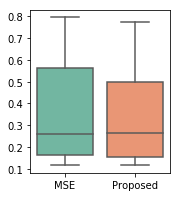

In [49]:
import seaborn as sns
val1 = []
for each in bestMSE:
    val1.append(np.mean(each))
val2 = []
for each in bestCOMBO:
    val2.append(np.mean(each))

val = []
for x, y in zip(val1, val2):
    val.append([x, y])
    
fig, ax = plt.subplots()
fig.set_size_inches(2.5,3)
df = pd.DataFrame(val, columns = ['MSE', 'Proposed'])
ax = sns.boxplot(ax = ax, data=df, palette="Set2")
fig.savefig('kaggle-bikeshare.pdf')
d = dict()
d['bestMSE'] = bestMSE
d['bestCOMBO'] = bestCOMBO


import pickle

with open('BikeShare.pkl', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [47]:
d = dict()
d['bestMSE'] = bestMSE
d['bestCOMBO'] = bestCOMBO


import pickle

with open('BikeShare.pkl', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [6]:
def get_average_improvement(df1, df2):
    ret = []
    for i, j in zip(df1,df2):
        ret.append(np.sum(j) - np.sum(i))
    return ret

improvement = get_average_improvement(bestMSE, bestCOMBO)

np.mean(bestMSE), np.mean(bestCOMBO),np.std(bestMSE), np.std(bestCOMBO), np.mean(improvement), np.std(improvement)

(0.07808901532949614,
 0.0734387598754572,
 0.011069054665139995,
 0.00980908366533528,
 -0.04650255454038939,
 0.050524876424333294)